## Course 1: Custom models, layers, and loss functions

In [1]:
import numpy as np
import tensorflow as tf
tf.__version__

'2.4.1'

### Siamese Network for Fashion MNIST



The key steps making this possible are

- our model architechture routes two inputs through a base network
- we take the L2 norm between vector outputs from each base model

By using the distance between each image embedding as the model output, 
we can then create a loss function that allows this embedding to be learned
along with the representations corresponding to similarity.



###### Base network

We use a base network to create an embedding for each image. $\theta_b: x_i \rightarrow v_i$ 

The dimensionality of $v$ depends on the number of nodes in the final layer,
which is set by `output_shape` declared above the model initializer.

In our case, $v\in\mathbb{R}^{32}$


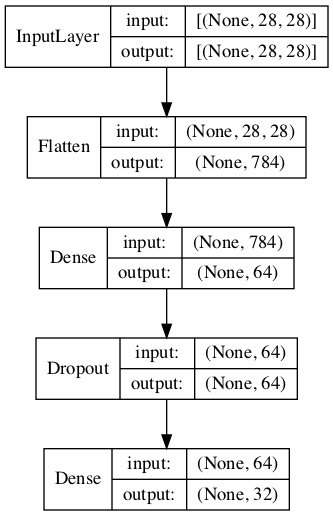

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

# Number of nodes in final dense layer
# and resulting embedding dimension
output_shape = 32

def initialize_base_network():
    
    input = layers.Input(shape=(28,28))
    x = layers.Flatten()(input)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(output_shape, activation='relu')(x)
    
    model = tf.keras.Model(input, x, name="base_network")
    return model

plot_model(initialize_base_network(), show_layer_names=False, show_shapes=True)

######  Siamese network



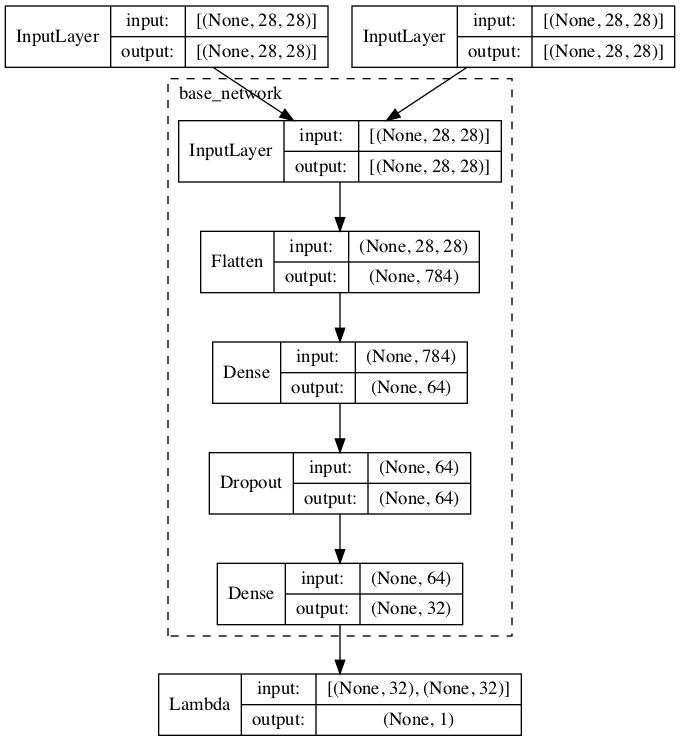

In [7]:
from keras import backend as K

def euclidean_distance(vectors):
    x, y = vectors
    sum_of_squared_difference = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_of_squared_difference, K.epsilon()))

def build_siamese_network_from_base():

    input_a = layers.Input(shape=(28,28))
    input_b = layers.Input(shape=(28,28))
    
    base_network = initialize_base_network()

    output_a = base_network(input_a)
    output_b = base_network(input_b)
    
    output = layers.Lambda(euclidean_distance, output_shape=output_shape)([output_a, output_b])
    model = tf.keras.Model([input_a, input_b], output)
    
    return model


model = build_siamese_network_from_base()

plot_model(model, 
           show_shapes=True,
           expand_nested=True,
           show_layer_names=False)

###### Prepare data


Given two image tensors $x_i$ and $x_j$ with classes $y_i$ and $y_j$,
we can train a *siamese network* that takes in image pairs and outputs their similarity.

The inputs/targets used to train this network are $X$ and $Y$,

where $X = (x_i, x_j) \mid x_i,x_j \in Images $,

and $Y = \begin{cases} 0 &\mbox{if } y_i\neq y_j \\ 1 & \mbox{if } y_i \equiv y_j \end{cases} $

In [13]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

def create_dataset(data, ratio=.2, balance_classes=True):

    images, labels = data
    indices = np.arange(len(labels))
    original = np.stack([indices, labels], axis=1)
    shuffled = np.stack([indices, labels], axis=1)

    X, y = [], []

    # Get pairs of images w/ labels corresponding to their class similarity
    np.random.shuffle(shuffled)
    X.extend(np.stack([images, images[shuffled[:,0]]], axis=1))
    y.extend([int(u==v) for u, v in zip(labels, shuffled[:,1])])

    
    # If balanced classes are desired (same number of samples for 0,1)
    if balance_classes == True:
        
        # Check if the class labels match for tuples of index/label pairs        
        is_same_class = lambda tuples: tuples[0][1]==tuples[1][1]
        
        # While the classes are imbalanced 
        while sum(y) / len(y) < ratio: # sum(y)/len(y) gives class ratio for binary data
            
            # Repeat process, adding only image pairs with matching classes
            np.random.shuffle(shuffled)
            image_pairs = [
                (images[index_label_pairs[0][0]], 
                 images[index_label_pairs[1][0]])
                for index_label_pairs in 
                filter(is_same_class, zip(original, shuffled))
            ]
            
            X.extend(image_pairs)
            y.extend([1]*len(image_pairs))

    return np.array(X) / 255, np.array(y)

# Prepare train/test sets
train, test = fashion_mnist.load_data()
X_train, y_train = create_dataset(train)
X_validation, y_validation = create_dataset(test)

# This shuffles our data and gives us a validation set
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=.1, random_state=0)

X_train.shape

(64797, 2, 28, 28)

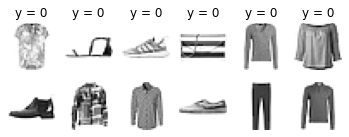

In [15]:
import matplotlib.pyplot as plt

def plot_samples(n_cols = 6):
    
    fig, ax = plt.subplots(2, n_cols, figsize=(n_cols, 2))

    for i in range(n_cols):
        
        top, bottom = ax[0][i], ax[1][i]
        top.axis('off'), bottom.axis('off')
        top.set_title("y = {}".format(y_train[i]))
        

        image_1, image_2 = X_train[i]
        top.imshow(image_1, cmap='Greys')
        bottom.imshow(image_2, cmap='Greys')


plot_samples()

###### Contrastive loss function

The loss function $L$ used to update the weights in our model
is defined as follows

$\\ L_{contrastive} = (1 - Y)\dfrac{1}{2}(D)^2 + (Y)\dfrac{1}{2}max(0, D_W) $

The **distance** $D$ is a learnable metric used to compute the
disparity between $x_i, x_j$, computed by the final layer's lambda function.


In [16]:
def ContrastiveLoss(margin=1.0):
    def contrastive_loss(y_true, y_pred):
        pred_squared = K.square(y_pred)
        y_true = tf.cast(y_true, dtype=tf.float32)
        margin_squared = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * pred_squared + (1 - y_true) * margin_squared)
    return contrastive_loss

###### Train model

In [17]:
# Final data form for training/validation
X_train_pairs = [X_train[:,0], X_train[:,1]]
validation_data = ([X_validation[:,0], 
                    X_validation[:,1]], 
                   y_validation)

# Compile
model.compile(optimizer=tf.keras.optimizers.RMSprop(), 
              loss=ContrastiveLoss(margin=1.0))

# Train
history = model.fit(X_train_pairs, 
                    y_train,
                    epochs=2, 
                    batch_size=16,
                    validation_data=validation_data)

Epoch 1/2
4050/4050 [==============================] - 13s 3ms/step - loss: 0.1609 - val_loss: 0.1071
Epoch 2/2
4050/4050 [==============================] - 11s 3ms/step - loss: 0.1023 - val_loss: 0.0814


In [18]:
picture_similarities = model.predict([X_test[:,0], X_test[:,1]])
picture_similarities

array([[0.15663555],
       [0.62690306],
       [0.90596235],
       ...,
       [0.9962133 ],
       [0.78309906],
       [1.7100345 ]], dtype=float32)

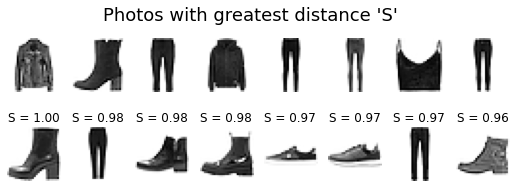

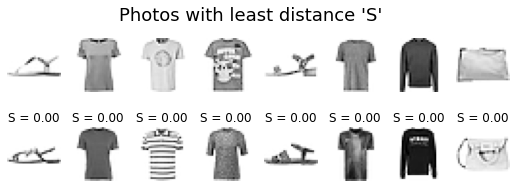

In [19]:
def plot_similar_photos(title, n_cols = 8, reverse=True):

    sim = [x[0] for x in picture_similarities]
    sort_asc = sorted(zip(sim, X_test), key=lambda x:x[0], reverse=reverse)  
    similarities = np.array([pair[0] for pair in sort_asc])
    similarities = (similarities - similarities.min()) / similarities.max() 
    
    photos = [pair[1] for pair in sort_asc]
    fig, ax = plt.subplots(2, n_cols, figsize=(n_cols+1, 3))

    for i in range(n_cols):
        
        top, bottom = ax[0][i], ax[1][i]
        top.axis('off'), bottom.axis('off')
        bottom.set_title(f"S = {similarities[i]:.2f}")

        image_1, image_2 = photos[i]
        top.imshow(image_1, cmap='Greys')
        bottom.imshow(image_2, cmap='Greys')

    plt.suptitle(title, fontsize=18)
    plt.show()

plot_similar_photos("Photos with greatest distance 'S'", reverse=True)
plot_similar_photos("Photos with least distance 'S'", reverse=False)

### Conclusion

Now that the method has been demonstrated, to get more accurate results
one might add to the base network in order to further reduce loss.

The lack of convolutions/pooling layers in the base network
probably means that there's little use for this architechture 
outside of toy use cases, but made training fairly quick on CPU-only machine.